In [ ]:
!pip install tensorflow opencv-python matplotlib numpy
!pip install roboflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 162.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 174.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 120.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 1

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="9PX08KDhvi9PBvP61JA9")
project = rf.workspace("sahan-2iobg").project("coral-semantic-segmentation")
version = project.version(4)
dataset = version.download("png-mask-semantic")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to coral-semantic-segmentation-4 in png-mask-semantic:: 100%|██████████| 652/652 [00:00<00:00, 15196.33it/s]


In [ ]:
import os
import cv2
import numpy as np

IMG_SIZE = 256

def load_data(folder_path):
    images = []
    masks = []

    for file in os.listdir(folder_path):
        if file.endswith(".jpg"):
            img_path = os.path.join(folder_path, file)
            mask_path = os.path.join(
                folder_path,
                file.replace(".jpg", "_mask.png")
            )

            # Image
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0

            # Mask (KEEP INTEGER VALUES)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
            mask = np.expand_dims(mask, axis=-1)

            images.append(img)
            masks.append(mask)

    return np.array(images), np.array(masks)



In [ ]:
train_images, train_masks = load_data("/content/coral-semantic-segmentation-4/train")
val_images, val_masks     = load_data("/content/coral-semantic-segmentation-4/valid")
test_images, test_masks   = load_data("/content/coral-semantic-segmentation-4/test")


In [ ]:
np.unique(train_masks)

array([0, 1, 2], dtype=uint8)

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 8
NUM_CLASSES = 3

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

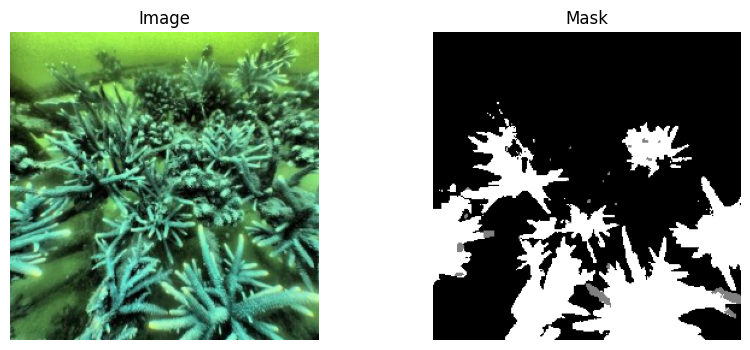

In [ ]:
import matplotlib.pyplot as plt

idx = 43

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Image")
plt.imshow(train_images[idx])
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Mask")
plt.imshow(train_masks[idx].squeeze(), cmap="gray")
plt.axis("off")


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

NUM_CLASSES = 3

def unet_model():
    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    # Bottleneck
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)

    # Decoder
    u4 = layers.UpSampling2D()(c3)
    u4 = layers.Concatenate()([u4, c2])
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(u4)

    u5 = layers.UpSampling2D()(c4)
    u5 = layers.Concatenate()([u5, c1])
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(u5)

    outputs = layers.Conv2D(NUM_CLASSES, 1, activation='softmax')(c5)

    return models.Model(inputs, outputs)


Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")


In [ ]:
model = unet_model()

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 128, 128,  │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 256, 256,  │          0 │ conv2d_6[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 192)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 256, 256,  │    110,656 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │        195 │ conv2d_7[0][0]    │
│                     │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,698,755 (6.48 MB)

 Trainable params: 1,698,755 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_images,
    train_masks,
    validation_data=(val_images, val_masks),
    epochs=40,
    batch_size=8
)


Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 678ms/step - accuracy: 0.7866 - loss: 0.6214 - val_accuracy: 0.8592 - val_loss: 0.4610
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 660ms/step - accuracy: 0.8724 - loss: 0.4438 - val_accuracy: 0.8592 - val_loss: 0.4275
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 661ms/step - accuracy: 0.8687 - loss: 0.4077 - val_accuracy: 0.8592 - val_loss: 0.4009
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 662ms/step - accuracy: 0.8856 - loss: 0.3686 - val_accuracy: 0.8592 - val_loss: 0.3737
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 656ms/step - accuracy: 0.8764 - loss: 0.3799 - val_accuracy: 0.8608 - val_loss: 0.3622
Epoch 6/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 674ms/step - accuracy: 0.8856 - loss: 0.3645 - val_accuracy: 0.8636 - val_loss: 0.4108
Epoch 7/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 660ms/step - accuracy: 0.8794 - loss: 0.3701 - val_accuracy: 0.8713 - val_loss: 0.3128
Epoch 8/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 657ms/step - accuracy: 0.8761 - loss: 0.3429 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

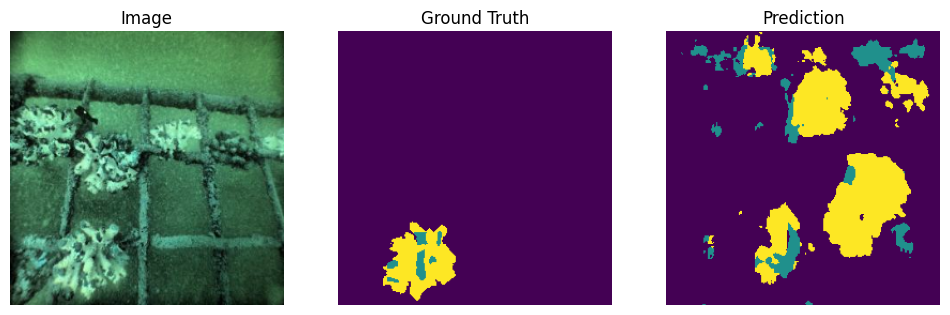

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

pred = model.predict(val_images[:1])
pred_mask = np.argmax(pred[0], axis=-1)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Image")
plt.imshow(val_images[2])
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Ground Truth")
plt.imshow(val_masks[2].squeeze(), cmap="viridis")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Prediction")
plt.imshow(pred_mask, cmap="viridis")
plt.axis("off")


In [ ]:
model.save("unet_coral_3class.h5")


In [ ]:
test_loss, test_accuracy = model.evaluate(
    test_images,
    test_masks,
    batch_size=8
)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9189 - loss: 0.2205
Test Loss: 0.22081536054611206
Test Accuracy: 0.9182938933372498


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Predict
pred = model.predict(test_images[:1])

# Convert softmax → class index (0,1,2)
pred_mask = np.argmax(pred[0], axis=-1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

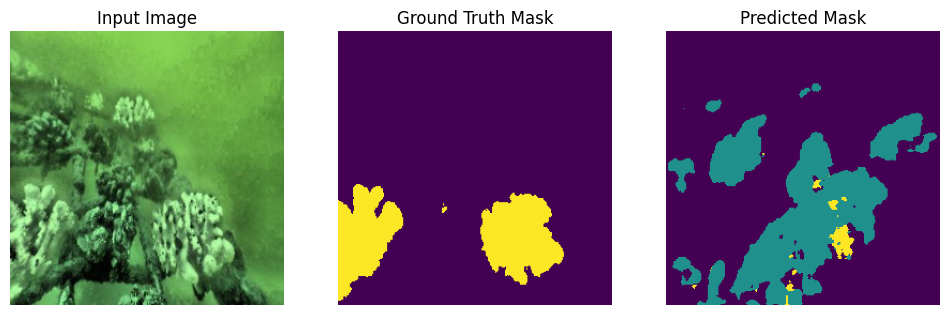

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(test_images[4])
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Ground Truth Mask")
plt.imshow(test_masks[4].squeeze(), cmap="viridis")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(pred_mask, cmap="viridis")
plt.axis("off")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


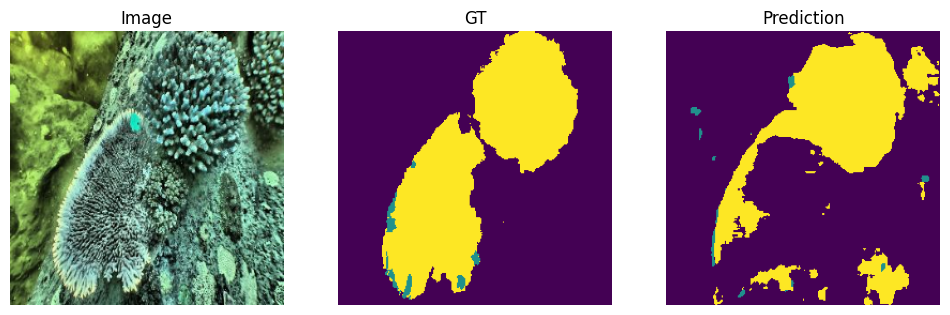

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


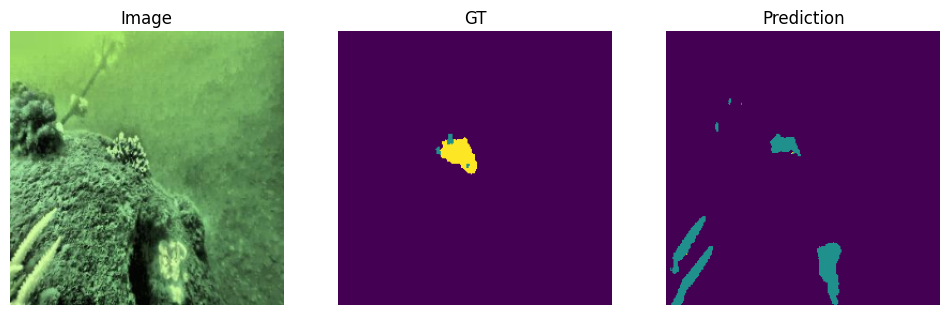

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


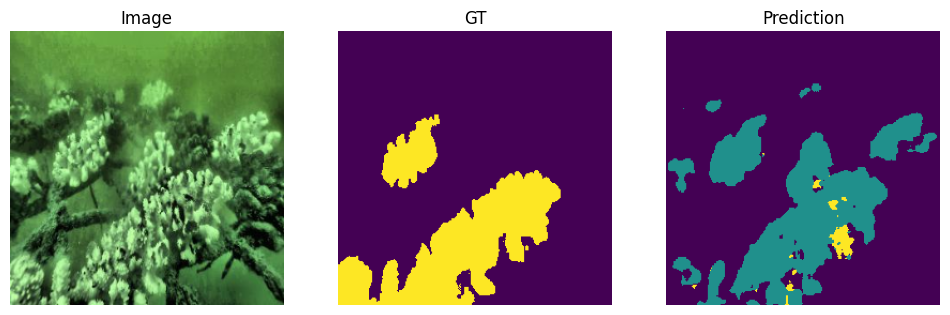

In [ ]:
num_samples = 3

for i in range(num_samples):
    pred = model.predict(test_images[i:i+1])
    pred_mask = np.argmax(pred[0], axis=-1)

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Image")
    plt.imshow(test_images[i])
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("GT")
    plt.imshow(test_masks[i].squeeze(), cmap="viridis")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.imshow(pred_mask, cmap="viridis")
    plt.axis("off")

    plt.show()
